RNN能够分析时间序列数据，例如网站上每天活跃用户的数量、城市每小时的温度、家里每日耗电量、附近汽车的轨迹等。一旦RNN学习了数据中过去的模式，它便能够利用这些知识来预测未来，当然，前提是过去的模式仍然在未来成立。

更一般地说，RNN能够针对任意长度的序列进行处理，而不是针对固定大小的输入。例如，它们可以将句子、文档或音频样本作为输入，因此在自然语言处理应用（比如自动翻译或语音识别）中非常有用。

介绍RNN的基本概念以及如何使用时域反向传播来对它们进行训练。

此外，将探讨RNN面临的两个主要问题：

- 不稳定的梯度，可以通过各种技术（包括循环Dropout和循环层归一化）来缓解。
- 非常有限的短期记忆，可以使用LSTM和GRU单元进行扩展。

然后，将使用它们来预测时间序列

## 循环神经元和层

前馈神经网络，其中激活仅在一个方向上流动，从输入层流向输出层。循环神经网络看起来非常像前馈神经网络，只不过它还具有反向的连接。

最简单的RNN：它由一个接收输入、产生输出并将输出反送回自身的神经元组成，如图（左）所示。在每个时间步长t（也称为帧），该循环神经元接收输入x(t)和前一个时间步长的输出ŷ(t-1)。由于在第一个时间步长中不涉及先前的输出，因此通常将其设置为0。可以沿时间轴来展开这个小网络，如图1（右）所示。这被称为时间展开网络（它是同一循环神经元在每个时间步长的表示）。

![循环神经元](./images/RNN/p1.png)

如下图所示，可以轻松地创建一个循环神经元层。在每个时间步长t，每个神经元接收输入向量x(t)和前一个时间步长的输出向量ŷ(t-1)。请注意，现在输入和输出都是向量（当只有一个神经元时，输出是标量）。

![一层循环神经元随时间展开](./images/RNN/p2.png)

每个循环神经元都有两组权重：一组用于输入x(t)，另一组用于前一个时间步长的输出ŷ(t-1)。我们称这些权重向量为wx和wŷ。如果考虑整个循环神经元层（简称“循环层”）而不仅仅是一个循环神经元，则可以将所有权重向量放在wx和wŷ这两个权重矩阵中。然后，可以如预期的那样计算整个循环层的输出向量，如公式所示，其中b是偏置向量，φ(·)是激活函数（例如ReLU)

- 公式：单个实例的循环层输出

$$
\hat{y}_{(t)} = \phi(W_x^{T}x_{(t)} + W_{\hat{y}}^{T}\hat{y}_{(t-1)} + b)
$$

就像前馈神经网络一样，可以通过将时间步长处的所有输入放在输入矩阵 $X_{(t)}$ 中，
来一次性计算出整个小批量的循环层输出（见下面公式 ）。

- 公式：一次传递中所有实例（小批量）的循环神经元层输出

$$
\hat{Y}_{(t)} = \phi(X_{(t)}W_x + \hat{Y}_{(t-1)}W_{\hat{y}} + b)
$$

也可以写成：

$$
\hat{Y}_{(t)} = \phi(([X_{(t)} \ \hat{Y}_{(t-1)}]W + b)), \quad
W =
\begin{bmatrix}
W_x \\
W_{\hat{y}}
\end{bmatrix}
$$

在此等式中：

- $\hat{Y}_{(t)}$ ：是一个 $m \times n_{\text{neurons}}$ 矩阵，包含小批量中每个实例在时间步长 $t$ 处该层的输出。
  （$m$ 是小批量中的实例数量，$n_{\text{neurons}}$ 是神经元数量。）

- $X_{(t)}$ ：是一个 $m \times n_{\text{inputs}}$ 矩阵，包含所有实例的输入。
  （$n_{\text{inputs}}$ 是输入特征的数量。）

- $W_x$ ：是一个 $n_{\text{inputs}} \times n_{\text{neurons}}$ 矩阵，包含当前时间步长的输入连接权重。

- $W_{\hat{y}}$ ：是一个 $n_{\text{neurons}} \times n_{\text{neurons}}$ 矩阵，包含前一时间步长的输出连接权重。

- $b$ ：是大小为 $n_{\text{neurons}}$ 的向量，包含每个神经元的偏置项。

- 权重矩阵 $W_x$ 和 $W_{\hat{y}}$ 经竖直重合并形成形状为 $(n_{\text{inputs}} + n_{\text{neurons}}) \times n_{\text{neurons}}$ 的单个权重矩阵 $W$（见公式 15-2 的第二行）。

- 符号 $[X_{(t)} \ \hat{Y}_{(t-1)}]$ 表示矩阵 $X_{(t)}$ 和 $\hat{Y}_{(t-1)}$ 的水平合并。


请注意：

- $\hat{Y}_{(t)}$ 是 $X_{(t)}$ 和 $\hat{Y}_{(t-1)}$ 的函数；
- 而 $\hat{Y}_{(t-1)}$ 是 $X_{(t-1)}$ 和 $\hat{Y}_{(t-2)}$ 的函数；
- $\hat{Y}_{(t-2)}$ 是 $X_{(t-2)}$ 和 $\hat{Y}_{(t-3)}$ 的函数；
以此类推。

这使 $\hat{Y}_{(t)}$ 成为自时间 $t=0$ 以来所有输入（即 $X_{(0)}, X_{(1)}, \ldots, X_{(t)}$）的函数。在第一个时间步长 $t=0$ 时，没有先前的输出，因此通常假定它们均为零。


### 记忆单元

由于在时间步长t时循环神经元的输出是先前时间步长中所有输入的函数，因此可以说它具有记忆的形式。神经网络中跨时间步长保留某些状态的部分称为记忆单元（简称单元）。单个循环神经元或循环神经元层是非常基本的单元，它只能学习短模式（通常约为10个步长）。后面将介绍一些能够学习更长模式（大约要长10倍）的更复杂、功能更强大的单元类型。单元在时间步长t的状态表示为h(t)［“h”代表“隐藏”(hidden)］，是该时间步长的某些输入和其前一个时间步长状态的函数：h(t)=f(h(t-1)，x(t))。它在时间步长t的输出表示为ŷ(t)，也是先前状态和当前输入的函数。就目前为止我们讨论的基本单元而言，输出等于状态。

### 输入序列和输出序列

RNN可以同时接收一个输入序列并产生一个输出序列。这种序列到序列的网络对于预测时间序列很有用，例如预测家里每日耗电量：将过去N天的数据输入它，然后训练它输出未来一天的耗电量（即从N-1天前到明天）。

或者，可以向网络提供一个输入序列，并忽略除了最后一个输出外的所有输出，这是一个序列到向量的网络。例如，可以向网络提供与电影评论相对应的单词序列，然后网络将输出一个情感得分［例如，从0（代表不喜欢）到1（代表喜欢）］。

相反，可以在每个时间步长中一次又一次地向网络提供相同的输入向量，并让其输出一个序列，这是一个向量到序列的网络。例如，输入可以是图像（或CNN的输出），而输出可以是该图像的描述文字。最后，可能有一个称为编码器的序列到向量的网络，后跟一个称为解码器的向量到序列的网络。例如，这可以用于将句子从一种语言翻译成另一种语言。可以用一种语言向网络输入一个句子，编码器会将其转换为单个向量表示，然后解码器会将此向量解码为另一种语言的句子。这种称为“编码器—解码器”(Encoder-Decoder)的两步模型比使用单个序列到序列的RNN进行即时翻译要好得多：句子的最后一个单词会影响翻译的第一个单词，因此在翻译之前需要等待，直到看完整个句子。

![序列到序列，序列到向量， 向量到序列，编码器-解码器](./images/RNN/p3.png)

### 随堂练习：简单RNN的前向传播

见其他文件夹

## 训练RNN

要训练RNN，诀窍是将其按照时间逐步展开，然后使用常规的反向传播。这种策略称为“时间反向传播”(BackPropagation Through Time，BPTT)。

就像在常规的反向传播中一样，首先通过展开的网络进行第一次前向传递（由虚线箭头表示）。然后，使用损失函数Loss(Y(0)，Y(1)，…，Y(T)；)（其中Y(i)）是第i个目标，Ŷ(i)是第i个预测结果，而T是最大时间步）评估输出序列。注意，此损失函数可能会忽略某些输出。例如，在序列到向量的RNN中，除了最后一个之外，所有输出都被忽略。在图中，仅基于最后三个输出计算损失函数。然后，将该损失函数的梯度通过展开的网络向后传播（由实线箭头表示）。在此示例中，由于输出Ŷ(0)和Ŷ(0)未用于计算损失，因此梯度不会向后流动，它们仅通过Ŷ(2)、Ŷ(3)和Ŷ(4)流动。此外，由于在每个时间步骤中使用相同的参数W和b，因此它们的梯度将在反向传播期间进行多次调整。完成反向阶段并计算出所有梯度后，BPTT可以执行梯度下降步骤来更新参数（这与常规反向传播没有区别）。

![RNN反向传播](./images/RNN/p1.jpg)

幸运的是，Keras为我们处理了所有这些复杂度

## RNN预测时间序列

在用RNN预测之前，先加载时间序列并使用经典工具开始分析它，以更好地理解要处理的问题，并获得一些基准指标。

In [1]:
import tensorflow as tf
from pathlib import Path

filepath = tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)
if "_extracted" in filepath:
    ridership_path = Path(filepath) / "ridership"
else:
    ridership_path = Path(filepath).with_name("ridership")

Exception: URL fetch failure on https://github.com/ageron/data/raw/main/ridership.tgz: None -- [Errno 11001] getaddrinfo failed

In [2]:
import pandas as pd
from pathlib import Path

path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  #  更短的名字
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # 不需要全部，只需要bus + rail
df = df.drop_duplicates()  # 删掉重复的月份 (2011-10 and 2014-07)

2001年1月1日，芝加哥有297192人乘坐公共汽车，126455人乘坐火车。day_type列包含W（表示工作日）、A（表示星期六），以及U（表示星期日或节假日）。

In [3]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


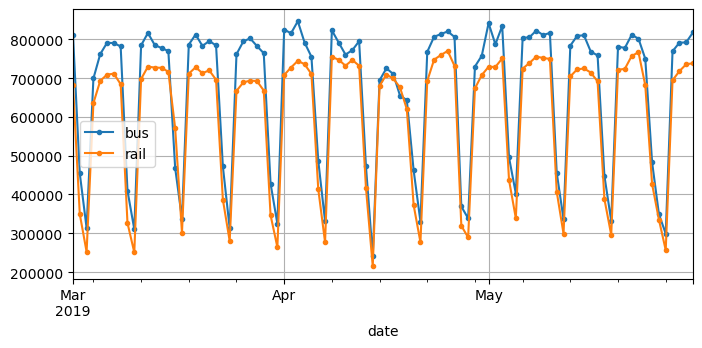

In [4]:
import matplotlib.pyplot as plt

# 2019年几个月的公共汽车和铁路客运量数据
df.loc["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

这是一个时间序列：具有不同时间步的值的数据，通常间隔固定。更具体地说，由于每个时间步有多个值，因此这称为多元时间序列。如果只查看bus列，它将是一元时间序列，每个时间步都有一个值。预测未来值（即预测）是处理时间序列时最典型的任务。其他任务包括插补（填补过去的缺失值）、分类、异常检测等。

从图中可以看到每周都有明显类似的模式。这称为每周季节性(seasonality)。

这个模式很强大，以至于仅通过复制一周前的值来预测明天的乘客量便可产生相当不错的结果。这称为朴素预测：通过简单地复制过去的值来做出预测。朴素预测通常是一个很好的基准，在某些情况下甚至很难被击败。

为了可视化这些朴素预测，我们用虚线叠加两个时间序列（bus和rail）以及滞后一周（即向右移动）的相同时间序列。还将绘制两者之间的差异（即时间t处的值减去时间t-7处的值），这称为差分

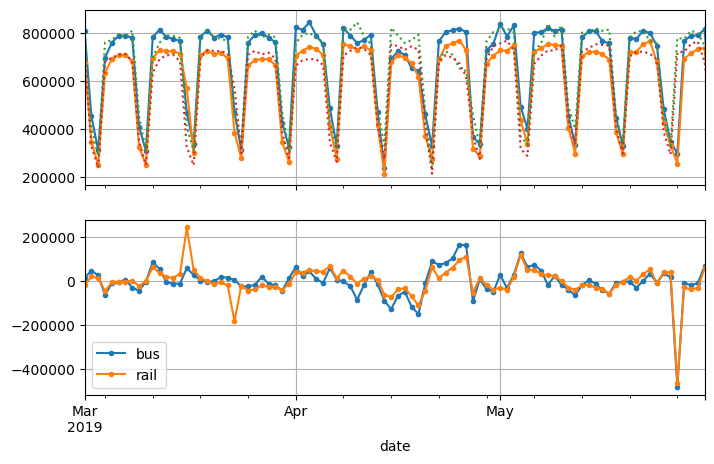

In [5]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  #  原始时间序列
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # 往后推的时间序列
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7天 差分的时间序列
axs[0].set_ylim([170_000, 900_000])  # 美化绘图
plt.show()

In [6]:
diff_7.abs().mean() # Mean absolute error (MAE), 或者是 mean absolute deviation (MAD)

# targets = df[["bus", "rail"]]["2019-03":"2019-05"]
# (diff_7 / targets).abs().mean() # Mean absolute percentage error (MAPE)

bus     43915.608696
rail    42143.271739
dtype: float64

现在我们有个基准（即朴素预测), 尝试使用到目前为止介绍的机器学习模型来预测这个时间序列，先从一个基本的线性模型开始。目标是根据过去8周（56天）的客运量数据来预测“明天”的客运量。因此，模型的输入将是序列（一旦模型投入生产，通常每天一个序列），每个序列包含从时间步t-55到t的56个值。对于每个输入序列，模型将输出一个值：时间步t+1的预测值。

如何准备训练数据：将使用过去的每个56天（作为窗口）作为训练数据，每个窗口对应的目标值将是紧随其后的值。

Keras实际上有一个很好的实用函数（叫作tf.keras.utils.timeseries_dataset_from_array()），它可以帮助准备训练集。它以时间序列作为输入，并构建一个包含所需长度的所有窗口及其相应目标值的tf.data.Dataset

In [7]:
import tensorflow as tf
my_series = [0,1,2,3,4,5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],
    sequence_length=3,
    batch_size=2
)
my_dataset

# 0 1 2 -> 3
# 1 2 3 ->  4
# 2 3 4  -> 5

<_BatchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [8]:
list(my_dataset)  #

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5])>)]

数据集中的每个样本都是一个长度为3的窗口，以及它对应的目标值（即紧接在窗口之后的值）。窗口是[0，1，2]、[1，2，3]和[2，3，4]，它们的目标值分别是3、4、5。由于一共有3个窗口，它不是批量大小的倍数，因此最后一个批次只包含一个窗口而不是两个。

获得相同结果的另一种方法是使用tf.data的Dataset类的window()方法。它更复杂，但它给了完全的控制权，window()方法返回窗口数据集的数据集

In [13]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


在此示例中，数据集包含6个窗口，每个窗口都比前一个窗口多移动一步，最后3个窗口较小，因为它们已到达序列的末尾

通常，将drop_remainder=True传递给window()方法来摆脱这些较小的窗口。window()方法返回一个嵌套的数据集，类似于列表的列表。当想要通过调用其数据集方法来转换每个窗口（例如，对它们进行乱序处理或对它们进行批处理）时，这很有用。但是，不能直接使用嵌套数据集进行训练，因为模型以张量而不是数据集为输入。因此，我们必须调用flat_map()方法：它将嵌套数据集转换为平面数据集（包含张量而不是数据集的数据集）。例如，假设{1，2，3}表示包含张量1、2和3序列的数据集，如果将嵌套数据集{{1，2}，{3，4，5，6}}展平，将得到平面数据集{1，2，3，4，5，6}。此外，flat_map()方法将一个函数作为参数，它允许在展平之前转换嵌套数据集中的每个数据集。例如，如果将函数lambda ds：ds.batch(2)传递给flat_map()，那么它会将嵌套数据集{{1，2}，{3，4，5，6}}转换为平面数据集{[1，2]，[3，4]，[5，6]}：它是一个包含3个张量的数据集，每个张量的大小为2。

In [12]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [13]:
# 创建辅助函数，更方便地从数据集提取窗口
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [14]:
# 使用map方法将每个窗口拆分为输入和目标值，然后将生成的窗口分组为大小为2的批次
dataset = to_windows(tf.data.Dataset.range(6), 4) # 0 1 2 3, 1 2 3 4, 2 3 4 5
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int64)>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4], dtype=int64)>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]], dtype=int64)>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5], dtype=int64)>)]

In [16]:
# 拆分训练，验证和测试，并归一化
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

接下来，使用timeseries_dataset_from_array()创建用于训练和验证的数据集。由于梯度下降期望训练集中的实例独立同分布(IID)，因此必须设置参数shuffle=True来打乱训练窗口

In [17]:
seq_length = 56
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
)

# train_ds : [32个，(x(y-55), ... x(t)), y(t+1)), 32个 (x(y-55), ... x(t)), y(t+1)) ... ]

### 使用线性模型进行预测

In [18]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])

history = model.fit(train_ds, validation_data=valid_ds, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 1s 8ms/step - loss: 0.1225 - mae: 0.3892 - val_loss: 0.0224 - val_mae: 0.1740
Epoch 2/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0142 - mae: 0.1261 - val_loss: 0.0068 - val_mae: 0.0882
Epoch 3/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0095 - mae: 0.1001 - val_loss: 0.0061 - val_mae: 0.0821
Epoch 4/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0089 - mae: 0.0981 - val_loss: 0.0057 - val_mae: 0.0777
Epoch 5/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0076 - mae: 0.0899 - val_loss: 0.0048 - val_mae: 0.0701
Epoch 6/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0063 - mae: 0.0795 - val_loss: 0.0048 - val_mae: 0.0685
Epoch 7/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0061 - mae: 0.0779 - val_loss: 0.0043 - val_mae: 0.0634
Epoch 8/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0055 - m

In [21]:
model.evaluate(valid_ds)[-1] * 1e6

3/3 [==============================] - 0s 3ms/step - loss: 0.0022 - mae: 0.0374


37405.166774988174

### 使用简单的RNN进行预测

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])


Keras中的所有循环层都期望形状为［批量大小、时间步、维度］的三维输入，其中一元时间序列的维度为1，多元时间序列的维度更高。回想一下，input_shape参数忽略了第一个维度（即批量大小），并且由于循环层可以接受任何长度的输入序列，因此可以将第二个维度设置为None，这意味着“任何大小”。

最后，由于我们处理的是一元时间序列，因此最后一个维度的大小应为1。这就是我们指定输入形状[None，1]的原因：它表示“任意长度的一元序列”。请注意，数据集实际上包含形状为［批量大小，时间步］的输入，因此缺少最后一个维度（大小为1），但在这种情况下Keras非常友好地为我们添加了它。

该模型的工作原理与之前看到RNN的完全一样：初始状态h(init)设置为0，并与第一个时间步的值x(0)一起被传递给单个循环神经元。神经元计算这些值的加权和加上偏置项，并将激活函数（默认情况下使用双曲正切函数(tanh）)应用于结果。结果是第一个输出y0。在简单的RNN中，这个输出也是新的状态h0。这个新状态与下一个输入值x(1)一起被传递到同一个循环神经元，重复上述过程直到最后一个时间步。最后，该层只输出最后一个值：在现在的数据示例中，序列步长为56，所以最后一个值是y55。所有这些都是针对批次中的每个序列（在本例中，每个批次有32个序列）同时执行的。

注意：Keras中的循环层仅返回最终输出。要使它们在每个时间步返回一个输出，必须设置return_sequences=True

这就是第一个应用到训练数据的循环模型！这是一个序列到向量的模型。由于只有一个输出神经元，因此输出向量的大小为1。现在，像之前一样编译、训练和评估这个模型：

In [22]:
# todo： 随堂练习， 编译，训练，并在训练结束后在验证集评估这个模型
def fit_and_evaluate(model, learning_rate, train_ds=train_ds, valid_ds=valid_ds):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_ds, validation_data=valid_ds, epochs=500, callbacks=[early_stopping_cb])

    print("验证集的误差: " + str(model.evaluate(valid_ds)[-1] * 1e6))


In [25]:
fit_and_evaluate(model, 0.02)

Epoch 1/500
33/33 [==============================] - 1s 11ms/step - loss: 0.0538 - mae: 0.2346 - val_loss: 0.0259 - val_mae: 0.1477
Epoch 2/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0173 - mae: 0.1626 - val_loss: 0.0160 - val_mae: 0.1340
Epoch 3/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0155 - mae: 0.1567 - val_loss: 0.0156 - val_mae: 0.1370
Epoch 4/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0154 - mae: 0.1540 - val_loss: 0.0153 - val_mae: 0.1404
Epoch 5/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0152 - mae: 0.1561 - val_loss: 0.0153 - val_mae: 0.1395
Epoch 6/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0152 - mae: 0.1552 - val_loss: 0.0153 - val_mae: 0.1380
Epoch 7/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0151 - mae: 0.1563 - val_loss: 0.0156 - val_mae: 0.1342
Epoch 8/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0151 - 

它的验证MAE大于100000！这是意料之中的，原因有二：
1. 该模型只有一个循环神经元，因此它在每个时间步可以用来进行预测的唯一数据是当前时间步的输入值和前一个时间步的输出值。换句话说，RNN的记忆极其有限：它只记忆一个数字，即它之前的输出。让我们数一数这个模型有多少个参数：因为该循环神经元只有2个输入值，所以整个模型只有3个参数（2个权重加上1个偏置项）。对于这个时间序列来说，这还远远不够。相比之下，我们之前的模型可以一次查看56个先前的值，它总共有57个参数。
2. 时间序列包含从0到大约1.4的值，但由于默认激活函数是tanh，因此循环层只能输出-1到+1之间的值。它无法预测1.0到1.4之间的值。让我们来解决这两个问题：我们将创建一个具有更大循环层（包含32个循环神经元）的模型，并在其顶部添加一个密集输出层（具有一个输出神经元且没有激活函数）。循环层能够将更多信息从一个时间步携带到下一个时间步，密集输出层将最终输出从32维投影到一维，没有任何值范围限制：

In [30]:
# todo: 随堂练习，用这个解决方案搭建模型，并编译，训练，在训练结束后在验证集评估这个模型，
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)
])

fit_and_evaluate(model, 0.02)

Epoch 1/500
33/33 [==============================] - 1s 12ms/step - loss: 0.0285 - mae: 0.1757 - val_loss: 0.0046 - val_mae: 0.0732
Epoch 2/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0053 - mae: 0.0741 - val_loss: 0.0033 - val_mae: 0.0572
Epoch 3/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0044 - mae: 0.0646 - val_loss: 0.0027 - val_mae: 0.0523
Epoch 4/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0039 - mae: 0.0604 - val_loss: 0.0029 - val_mae: 0.0531
Epoch 5/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0038 - mae: 0.0593 - val_loss: 0.0025 - val_mae: 0.0488
Epoch 6/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0036 - mae: 0.0558 - val_loss: 0.0024 - val_mae: 0.0477
Epoch 7/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0034 - mae: 0.0545 - val_loss: 0.0024 - val_mae: 0.0475
Epoch 8/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0034 - 

In [31]:
model.predict(valid_ds.take(1)).shape

1/1 [==============================] - 0s 180ms/step


(32, 1)

会发现它的验证MAE击败了朴素预测和线性回归，是迄今训练过的最好模型

### 使用深度RNN进行预测

堆叠多层单元可以产生深度RNN

![深度RNN随时间展开](./images/RNN/p4.png)

使用Keras实现深度RNN非常简单：只需堆叠循环层即可。在下面的示例中，使用3个SimpleRNN层,前两个是序列到序列的层，最后一个是序列到向量的层。最后，Dense层（可以将其视为向量到向量的层）生成模型的预测值。所以，这个模型就像图中表示的模型一样，只不过输出Ŷ(0)到Ŷ(t-1)被忽略，并且在Ŷ(t)之上有一个密集层，它输出实际的预测值：

In [32]:
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

确保为所有循环层设置return_sequences=True（最后一层除外）。如果你忘记为某个循环层设置此参数，它将输出一个仅包含最后一个时间步的输出的二维数组，而不是包含所有时间步的输出的三维数组。下一个循环层会报错：没有以预期的三维格式为其提供序列。

如果训练并评估这个模型，它并没有打败“较浅”的RNN。看起来这个RNN对于我们的任务来说有点太大了。

In [33]:
fit_and_evaluate(deep_model, 0.02)

Epoch 1/500
33/33 [==============================] - 3s 26ms/step - loss: 0.0152 - mae: 0.1402 - val_loss: 0.0030 - val_mae: 0.0575
Epoch 2/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0052 - mae: 0.0707 - val_loss: 0.0023 - val_mae: 0.0457
Epoch 3/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0049 - mae: 0.0663 - val_loss: 0.0022 - val_mae: 0.0405
Epoch 4/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0046 - mae: 0.0640 - val_loss: 0.0035 - val_mae: 0.0647
Epoch 5/500
33/33 [==============================] - 1s 17ms/step - loss: 0.0055 - mae: 0.0757 - val_loss: 0.0042 - val_mae: 0.0710
Epoch 6/500
33/33 [==============================] - 1s 17ms/step - loss: 0.0048 - mae: 0.0684 - val_loss: 0.0021 - val_mae: 0.0403
Epoch 7/500
33/33 [==============================] - 1s 20ms/step - loss: 0.0046 - mae: 0.0669 - val_loss: 0.0058 - val_mae: 0.0902
Epoch 8/500
33/33 [==============================] - 1s 16ms/step - loss: 0.

In [32]:
deep_model.evaluate(valid_ds)

3/3 [==============================] - 0s 15ms/step - loss: 0.0017 - mae: 0.0301


[0.0017450390150770545, 0.030073534697294235]

### 多元时间序列预测

神经网络的一大优点是它们非常灵活，特别是，它们可以处理多元时间序列而几乎无须改变它们的架构。例如，尝试使用公共汽车和铁路数据作为输入来预测铁路时间序列。事实上，还可以加入日期类型，由于可以提前知道明天是工作日、周末还是假期，因们可以将日期类型序列偏移一天，这样模型就可以将“明天”的日期类型作为输入了。为了简单起见，将使用Pandas进行此处理：

In [35]:
df_mulvar = df[["bus", "rail"]] / 1e6
df_mulvar["next_day_type"] = df["day_type"].shift(-1)
df_mulvar

df_mulvar = pd.get_dummies(df_mulvar, dtype=float)
df_mulvar

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2001-01-01,0.297192,0.126455,0.0,0.0,1.0
2001-01-02,0.780827,0.501952,0.0,0.0,1.0
2001-01-03,0.824923,0.536432,0.0,0.0,1.0
2001-01-04,0.870021,0.550011,0.0,0.0,1.0
2001-01-05,0.890426,0.557917,1.0,0.0,0.0
...,...,...,...,...,...
2021-11-26,0.257700,0.189694,1.0,0.0,0.0
2021-11-27,0.237839,0.187065,0.0,1.0,0.0
2021-11-28,0.184817,0.147830,0.0,0.0,1.0


现在df_mulvar是一个包含5列的DataFrame，这5列分别是公共汽车数据列、铁路数据列，以及包含第二天类型的独热编码的3列（有3种可能的日期类型W、A和U）。接下来可以重复之前的操作。首先，将数据分成训练、验证和测试：

In [37]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [39]:
tf.random.set_seed(42)
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  # 使用5列作为输入
    targets=mulvar_train["rail"][seq_length:],  # 只预测铁路序列
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [40]:
tf.random.set_seed(42)
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

In [42]:
fit_and_evaluate(mulvar_model, 0.02, train_ds = train_mulvar_ds, valid_ds = valid_mulvar_ds)

Epoch 1/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0572 - mae: 0.2551 - val_loss: 0.0034 - val_mae: 0.0601
Epoch 2/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0040 - mae: 0.0664 - val_loss: 0.0014 - val_mae: 0.0376
Epoch 3/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0024 - mae: 0.0472 - val_loss: 0.0015 - val_mae: 0.0433
Epoch 4/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0020 - mae: 0.0438 - val_loss: 0.0019 - val_mae: 0.0517
Epoch 5/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0018 - mae: 0.0411 - val_loss: 0.0012 - val_mae: 0.0380
Epoch 6/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0017 - mae: 0.0402 - val_loss: 0.0015 - val_mae: 0.0465
Epoch 7/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0017 - mae: 0.0404 - val_loss: 0.0011 - val_mae: 0.0378
Epoch 8/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0015 - 

它与univar_model RNN的唯一区别是输入形状不同：在每个时间步，该模型接收5个输入而不是1个。该模型实际的验证MAE达到了23000左右。 取得了很大的进步！

让RNN同时预测公共汽车和铁路客运量并不难，只需要在创建数据集时更改目标，针对训练集将它们设置为mulvar_train[["bus"，"rail"]][seq_length：]，针对验证集设置为mulvar_valid[["bus"，"rail"]][seq_length：]。还必须在输出Dense层中添加一个额外的神经元，因为它现在必须进行两项预测：一项针对明天的公共汽车客运量，另一项针对铁路客运量

对多个相关任务使用单个模型可能会比对每个任务使用单独的模型产生更好的性能，不仅因为针对一个任务学习的特征可能对其他任务也有用，而且还因为必须跨多个任务表现良好可以防止模型过拟合

In [43]:
tf.random.set_seed(42)

seq_length = 56
train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train[["bus", "rail"]][seq_length:],  # 2个目标
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

tf.random.set_seed(42)
multask_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2)
])

fit_and_evaluate(multask_model, 0.02, train_multask_ds, valid_multask_ds)

Epoch 1/500
33/33 [==============================] - 2s 24ms/step - loss: 0.0379 - mae: 0.1828 - val_loss: 0.0039 - val_mae: 0.0712
Epoch 2/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0031 - mae: 0.0569 - val_loss: 0.0018 - val_mae: 0.0486
Epoch 3/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0023 - mae: 0.0467 - val_loss: 9.6673e-04 - val_mae: 0.0322
Epoch 4/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0020 - mae: 0.0450 - val_loss: 0.0019 - val_mae: 0.0514
Epoch 5/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0020 - mae: 0.0442 - val_loss: 7.7440e-04 - val_mae: 0.0286
Epoch 6/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0018 - mae: 0.0416 - val_loss: 0.0010 - val_mae: 0.0336
Epoch 7/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0017 - mae: 0.0409 - val_loss: 7.7338e-04 - val_mae: 0.0285
Epoch 8/500
33/33 [==============================] - 0s 7ms/step - los

In [47]:
# 评估多任务RNN的预测
Y_preds_valid = multask_model.predict(valid_multask_ds)
Y_preds_valid
for idx, name in enumerate(["bus", "rail"]):
    mae = 1e6 * tf.keras.metrics.MeanAbsoluteError()(
        mulvar_valid[name][seq_length:], Y_preds_valid[:, idx])
    print(name, int(mae))

3/3 [==============================] - 0s 4ms/step
bus 25608
rail 26465


### 预测未来多个时间步

到目前为止，只预测了下一个时间步的值，但通过适当地改变目标我们可以预测未来多个时间步的值（例如，要预测未来2周的客运量，只需将目标更改为未来14天的值而不是1天后的值）

训练RNN一次性预测未来的14个值。仍然可以使用序列到向量的模型，但它会输出14个值而不是1个值。但是，首先需要将目标更改为包含接下来的14个值的向量。为此，可以再次使用timeseries_dataset_from_array()，但这次要求它创建没有目标(targets=None)且更长的序列的数据集，长度为seq_length+14。然后，可以使用数据集的map()方法将自定义函数应用于每批序列，将它们拆分为输入和目标值。在这个例子中，使用多元时间序列作为输入（使用所有5列），预测未来14天的铁路客运量

In [49]:
def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    # (32, 70, 5)
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]


ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length+14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)

ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length+14,
    batch_size=32).map(split_inputs_and_targets)

In [51]:
# 输出用14个单元
ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [52]:
fit_and_evaluate(ahead_model, 0.02, ahead_train_ds, ahead_valid_ds)

Epoch 1/500
33/33 [==============================] - 1s 12ms/step - loss: 0.0964 - mae: 0.3233 - val_loss: 0.0238 - val_mae: 0.1617
Epoch 2/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0169 - mae: 0.1504 - val_loss: 0.0137 - val_mae: 0.1234
Epoch 3/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0130 - mae: 0.1314 - val_loss: 0.0112 - val_mae: 0.1123
Epoch 4/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0112 - mae: 0.1213 - val_loss: 0.0092 - val_mae: 0.1041
Epoch 5/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0100 - mae: 0.1141 - val_loss: 0.0085 - val_mae: 0.0963
Epoch 6/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0091 - mae: 0.1076 - val_loss: 0.0074 - val_mae: 0.0916
Epoch 7/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0085 - mae: 0.1022 - val_loss: 0.0068 - val_mae: 0.0876
Epoch 8/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0080 - 

In [62]:
# 训练好后 一次预测接下来的14个值
import numpy as np
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]  # shape [1, 56, 5]
Y_pred = ahead_model.predict(X)  # shape [1, 14]

1/1 [==============================] - 0s 75ms/step


### 使用序列到序列模型进行预测

与其训练模型仅在最后一个时间步预测接下来的14个值，不如训练它在每个时间步预测接下来的14个值。换句话说，可以将这个序列到向量的循环神经网络转变为序列到序列的循环神经网络。这种技术的优点是损失将包含RNN在每个时间步的输出的损失项，而不仅仅包含最后一个时间步的输出的损失项。

这意味着将有更多的误差梯度流过模型，并且它们不必在时间中流动那么多，因为它们来自每个时间步的输出，而不仅仅是来自最后一个时间步。这既能稳定训练，又能加速训练。

需要明确的是，在时间步0，模型将输出一个向量，其中包含时间步1到14的预测值。在时间步1，模型将预测时间步2到15的值，以此类推。换句话说，目标是连续窗口的序列，在每个时间步移动一个时间步。目标不再是向量，而是与输入长度相同的序列，每一步都包含一个14维向量。

准备数据集并不简单，因为每个实例都有一个作为输入的窗口和一个作为输出的窗口序列。一种方法是使用之前创建的to_windows()实用函数，连续两次，获取连续窗口的窗口。例如，将数字0到6的序列转换为包含4个连续窗口的序列的数据集，每个窗口的长度为3：

In [68]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]], dtype=int64)>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]], dtype=int64)>]

In [69]:
# 可以使用map()方法将这些窗口的窗口拆分为输入和目标
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3], dtype=int64)>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]], dtype=int64)>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4], dtype=int64)>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]], dtype=int64)>)]

现在数据集包含长度为4的序列作为输入，目标是包含每个时间步的接下来两个步骤的序列。例如，第一个输入序列是[0，1，2，3]，它对应的目标是[[1，2]，[2，3]，[3，4]，[4，5]]，即每个时间步的下两个值。

In [70]:
# 创建辅助函数为序列到序列模型准备数据集。
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1, batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead+1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)


In [75]:
# 创建数据集
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

# 构建序列模型
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

它与之前的模型几乎相同：唯一的区别是我们在SimpleRNN层中设置了return_sequences=True。这样，它将输出一个向量（每个大小为32）序列，而不是在最后一个时间步输出单个向量。Dense层足够智能，可以将序列作为输入处理：它将在每个时间步应用，将32维向量作为输入并输出14维向量。事实上，另一种获得完全相同结果的方法是使用核大小为1的Conv1D层：Conv1D(14，kernel_size=1)。

In [76]:
seq2seq_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_12 (SimpleRNN)   (None, None, 32)          1216      
                                                                 
 dense_10 (Dense)            (None, None, 14)          462       
                                                                 
Total params: 1678 (6.55 KB)
Trainable params: 1678 (6.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


训练代码和平时一样。在训练过程中，模型的所有输出都会被使用，但训练后只有最后一个时间步的输出很重要，其余的可以忽略。

In [77]:
opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
seq2seq_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = seq2seq_model.fit(seq2seq_train, validation_data=seq2seq_valid, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 1s 11ms/step - loss: 0.0681 - mae: 0.2645 - val_loss: 0.0142 - val_mae: 0.1272
Epoch 2/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0092 - mae: 0.1002 - val_loss: 0.0069 - val_mae: 0.0811
Epoch 3/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0064 - mae: 0.0785 - val_loss: 0.0057 - val_mae: 0.0707
Epoch 4/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0055 - mae: 0.0707 - val_loss: 0.0052 - val_mae: 0.0661
Epoch 5/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0050 - mae: 0.0664 - val_loss: 0.0048 - val_mae: 0.0621
Epoch 6/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0048 - mae: 0.0645 - val_loss: 0.0048 - val_mae: 0.0632
Epoch 7/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0046 - mae: 0.0628 - val_loss: 0.0047 - val_mae: 0.0618
Epoch 8/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0044 - 

In [83]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(X)[0,-1] # 只需要最后一个时间步的输出

1/1 [==============================] - 0s 20ms/step


In [87]:
Y_pred_valid = seq2seq_model.predict(seq2seq_valid)
for ahead in range(14):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=mulvar_valid.index[56 + ahead : -14 + ahead]) # 因为最后几个窗口没有完整 14 步预测（靠近结尾的数据不足），所以这里裁掉最后 14 步，保证索引与预测数组 Y_pred_valid[:-1] 长度匹配。
    mae = (preds - mulvar_valid["rail"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")


3/3 [==============================] - 0s 5ms/step
MAE for +1: 23,222
MAE for +2: 27,877
MAE for +3: 32,001
MAE for +4: 31,346
MAE for +5: 31,939
MAE for +6: 33,802
MAE for +7: 33,435
MAE for +8: 34,440
MAE for +9: 33,686
MAE for +10: 32,397
MAE for +11: 36,805
MAE for +12: 36,716
MAE for +13: 34,703
MAE for +14: 34,634


## 处理长序列

简单的RNN可以很好地预测时间序列或处理其他类型的序列，但它们在长时间序列上表现不佳。要在长序列上训练RNN，必须在许多时间步上运行它，使展开的RNN成为一个非常深的网络。就像所有深度神经网络一样，它可能会遇到不稳定梯度问题：训练可能需要很长时间，或者训练可能不稳定。此外，当RNN处理一个长序列时，它会逐渐忘记序列中的第一个输入。所以长序列的训练需要解决不稳定梯度和遗忘问题，先看看不稳定梯度问题

### 解决不稳定的梯度问题

在深度网络中用于缓解不稳定梯度问题的许多技巧也可用于RNN：良好的参数初始化、更快的优化器、dropout等。然而，非饱和激活函数（例如ReLU）在这里可能没有那么大的帮助。事实上，它们实际上可能导致RNN在训练过程中变得更加不稳定。为什么？假设梯度下降以一种在第一个时间步略微增加输出的方式更新权重。因为在每个时间步都使用相同的权重，所以第二个时间步的输出可能略有增加，第三个时间步的输出也可能略有增加，以此类推，直到输出爆炸——非饱和激活函数不会阻止这种情况的发生。

我们可以通过较小的学习率来降低这种风险，或者可以使用像双曲正切函数这样的饱和激活函数（这解释了为什么它是默认值）。

以几乎相同的方式，梯度本身也可能爆炸。如果你注意到训练不稳定，那么可能需要监控梯度的大小（例如使用TensorBoard）并使用梯度裁剪。

此外，批量归一化不能像在深度前馈网络中那样有效地用于RNN。事实上，我们不能在时间步之间使用它，只能在循环层之间使用它。

更准确地说，在技术上可以将BN层添加到记忆单元，以便在每个时间步（在该时间步的输入和上一步的隐藏状态上）应用它。然而，无论输入和隐藏状态的实际尺度和偏移量如何，每个时间步都将使用相同的BN层（具有相同的参数）。实际上，这并没有产生好的结果，2015年的论文发现BN仅在应用于层的输入而不是隐藏状态时才略微有益。换句话说，在循环层之间（垂直方向）应用它比没有应用效果稍微好一点，但不应在循环层内（水平方向）应用。在Keras中，可以通过在每个循环层之前添加BatchNormalization层来简单地在层之间应用BN，但这会减慢训练速度，而且可能没有太大帮助。

另一种形式的归一化通常更适用于RNN：层归一化。它与批量归一化非常相似，但层归一化不是跨批量维度归一化，而是跨特征维度归一化。它的一个优点是可以在每个时间步独立地为每个实例即时计算所需的统计数据。这也意味着它在训练和测试期间的行为方式相同（与BN不同），并且它不需要像BN那样使用指数移动平均来估计训练集中所有实例的特征统计量。与BN一样，层归一化为每个输入学习一个尺度和一个偏移参数。在RNN中，它通常在输入和隐藏状态的线性组合之后立即使用。

In [110]:
# 回顾作业10的一道题，理解 层归一化的代码实现
class MyLayerNormalization(tf.keras.layers.Layer):
    def build(self, input_shape):
        self.alpha = tf.ones(input_shape[-1:])
        self.beta = tf.zeros(input_shape[-1:])

    def call(self, X):
        mean, var = tf.nn.moments(X, axes=-1, keepdims=True)
        return self.alpha * (X - mean) / (tf.sqrt(var) + 1e-7) + self.beta



In [111]:
tensor_random = tf.random.normal([32, 56, 5])
# MyLayerNormalization()(tensor_random)

a1 = tf.keras.layers.LayerNormalization(epsilon=1e-7)(tensor_random).numpy()
a2 = MyLayerNormalization()(tensor_random).numpy()

np.max(np.abs(a1-a2))

6.556511e-06

请注意，states参数是一个包含一个或多个张量的列表。在简单的RNN单元下，它包含一个等于前一个时间步的输出的张量，但其他单元可能有多个状态张量（例如，LSTMCell有一个长期状态和一个短期状态）。单元还必须具有state_size属性和output_size属性。在简单的RNN中，两者都等于单元数。以下代码实现了一个自定义记忆单元，其行为类似于SimpleRNNCell，只不过它还会在每个时间步应用层归一化：

In [113]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

- LNSimpleRNNCell类继承自tf.keras.layers.Layer类，就像其他自定义层一样。
- 构造函数接受单元数和所需的激活函数并设置state_size和output_size属性，然后创建一个没有激活函数的SimpleRNNCell（因为想在线性操作之后、激活函数之前执行层归一化）。
- 之后，构造函数创建LayerNormalization层，最后它获取所需的激活函数。
- call()方法首先应用SimpleRNNCell，它计算当前输入和先前隐藏状态的线性组合，并返回结果两次（实际上，在SimpleRNNCell中，输出正好等于隐藏状态，换句话说，new_states[0]等于outputs，所以可以忽略call()方法其余部分中的new_states）。接下来，call()方法应用层归一化，然后应用激活函数。
- 最后，它返回输出两次：一次作为输出，一次作为新的隐藏状态。要使用这个自定义单元，需要做的就是创建一个tf.keras.layers.RNN层，并向它传递一个单元实例：

In [114]:
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True,
                        input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [115]:
opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
custom_ln_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = custom_ln_model.fit(seq2seq_train, validation_data=seq2seq_valid, epochs=5, callbacks=[early_stopping_cb])

Epoch 1/5
33/33 [==============================] - 1s 18ms/step - loss: 0.0881 - mae: 0.2984 - val_loss: 0.0199 - val_mae: 0.1515
Epoch 2/5
33/33 [==============================] - 0s 13ms/step - loss: 0.0153 - mae: 0.1467 - val_loss: 0.0161 - val_mae: 0.1339
Epoch 3/5
33/33 [==============================] - 0s 13ms/step - loss: 0.0132 - mae: 0.1361 - val_loss: 0.0149 - val_mae: 0.1268
Epoch 4/5
33/33 [==============================] - 0s 13ms/step - loss: 0.0122 - mae: 0.1291 - val_loss: 0.0142 - val_mae: 0.1228
Epoch 5/5
33/33 [==============================] - 0s 13ms/step - loss: 0.0113 - mae: 0.1224 - val_loss: 0.0129 - val_mae: 0.1179


同样，可以创建一个自定义单元以在每个时间步之间应用dropout。但是，有一个更简单的方法：Keras提供的大多数循环层和单元都有dropout和recurrent_dropout超参数：前者定义应用于输入的dropout率，后者定义时间步之间隐藏状态的dropout率。因此，无须创建自定义单元来在RNN的每个时间步应用dropout。使用这些技术，可以缓解不稳定的梯度问题并有效地训练RNN

### 处理短期记忆问题

由于数据在遍历RNN时会经历转换，因此在每个时间步都会丢失一些信息。一段时间后，RNN的状态几乎不包含第一个输入的踪迹。为了解决这个问题，人们引入了具有长期记忆的各种类型的单元。它们已被证明非常成功，以至于基本单元不再被大量使用。首先看看这些长期记忆单元中最受欢迎的LSTM单元。

#### LSTM单元

长短期记忆(Long Short-Term Memory，LSTM)单元于1997年首次提出，多年来由研究人员逐步改进。如果将LSTM单元视为黑盒，它可以像基本单元一样使用，但性能要好得多：训练会收敛得更快，并且能够检测数据中的长期模式。在Keras中，可以简单地使用LSTM层而不是SimpleRNN层：

In [116]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [117]:
opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(seq2seq_train, validation_data=seq2seq_valid, epochs=5, callbacks=[early_stopping_cb])

Epoch 1/5
33/33 [==============================] - 2s 18ms/step - loss: 0.0579 - mae: 0.2612 - val_loss: 0.0189 - val_mae: 0.1695
Epoch 2/5
33/33 [==============================] - 0s 11ms/step - loss: 0.0175 - mae: 0.1594 - val_loss: 0.0178 - val_mae: 0.1472
Epoch 3/5
33/33 [==============================] - 0s 11ms/step - loss: 0.0159 - mae: 0.1523 - val_loss: 0.0169 - val_mae: 0.1441
Epoch 4/5
33/33 [==============================] - 0s 11ms/step - loss: 0.0152 - mae: 0.1485 - val_loss: 0.0163 - val_mae: 0.1403
Epoch 5/5
33/33 [==============================] - 0s 11ms/step - loss: 0.0146 - mae: 0.1449 - val_loss: 0.0158 - val_mae: 0.1370


LSTM单元架构如图所示。如果不看黑盒里面的东西，LSTM单元看起来就像一个普通单元，除了它的状态被分成两个向量：h(t)和c(t)［“c”代表“单元”(cell)］。可以将h(t)视为短期状态，将c(t)视为长期状态。

![LSTM单元](./images/RNN/p5.png)

关键思想是网络可以学习在长期状态中存储什么，丢弃什么，以及从中读取什么。当长期状态c(t-1)从左到右遍历网络时，它首先通过遗忘门，丢弃一些记忆，然后通过加法运算添加一些新记忆（添加由输入门选择的记忆）。结果c(t)直接被发送出去，没有进行进一步的转换。因此，在每个时间步，都会删除一些记忆并添加一些记忆。而且，在加法运算之后，复制长期状态并使用tanh函数，然后通过输出门对结果进行过滤。这会产生短期状态h(t)（等于此时间步的单元输出）。

现在看看新的记忆是从哪里来的，以及这些门是如何工作的。首先，当前输入向量x(t)和先前的短期状态h(t-1)被馈送到4个不同的全连接层。它们都有不同的用途：
- 主要的层是输出g(t)的层。它具有分析当前输入x(t)和先前（短期）状态h(t-1)的作用。在基本单元中，除了这一层外别无其他，它的输出直接输出到ŷ(t)和h(t)。但是，在LSTM单元中，该层的输出不会直接输出，相反，它最重要的部分存储在长期状态中（其余部分被丢弃）。
- 其他三层是门控制器。由于它们使用逻辑(logistic)激活函数，输出范围为0～1。门控制器的输出被馈送到逐元素乘法运算单元：如果它们输出0，则关闭门；如果输出1，则打开门。具体来说：

◆ 遗忘门（由f(t)控制）控制应擦除长期状态的哪些部分。

◆ 输入门（由i(t)控制）控制g(t)的哪些部分应添加到长期状态。

◆ 输出门（由o(t)控制）控制应在该时间步读取和输出长期状态的哪些部分，包括h(t)和y(t)。

简而言之，LSTM单元可以学习识别重要输入（这是输入门的作用），将其存储在长期状态中，在需要时保留它（这是遗忘门的作用），并在需要时提取它。这就解释了为什么这些单元在捕捉时间序列、长文本、录音等的长期模式方面取得了惊人的成功。

下面公式总结了如何计算单元的长期状态，短期状态以及单个实例在每个时间步的输出。

公式：LSTM的计算

$$
\begin{aligned}
i_{(t)} &= \sigma\left(W_{xi}^{\top} x_{(t)} + W_{hi}^{\top} h_{(t-1)} + b_i \right) \\
f_{(t)} &= \sigma\left(W_{xf}^{\top} x_{(t)} + W_{hf}^{\top} h_{(t-1)} + b_f \right) \\
o_{(t)} &= \sigma\left(W_{xo}^{\top} x_{(t)} + W_{ho}^{\top} h_{(t-1)} + b_o \right) \\
g_{(t)} &= \tanh\left(W_{xg}^{\top} x_{(t)} + W_{hg}^{\top} h_{(t-1)} + b_g \right) \\
c_{(t)} &= f_{(t)} \otimes c_{(t-1)} + i_{(t)} \otimes g_{(t)} \\
h_{(t)} &= o_{(t)} \otimes \tanh\left(c_{(t)}\right) \\
y_{(t)} &= h_{(t)}
\end{aligned}
$$

在这个等式中：
- Wxi、Wxf、Wxo和Wxg是4个层连接到输入向量x(t)的权重矩阵。
- Whi、Whf、Who和Whg是4个层的权重矩阵，用于连接到先前的短期状态h(t-1)。
- bi、bf、bo和bg是4个层的偏置项。请注意，TensorFlow将bf初始化为一个全1而不是全0的向量。这可以防止在训练开始时忘记一切。


In [118]:
# todo: 随堂练习：LSTM的前向传播实现，见其他文件夹

#### GRU单元

GRU单元是LSTM单元的简化版本，它的表现和LSTM差不多，以下是主要的简化：

- 两个状态向量合并为一个向量h(t)。
- 单个门控制器z(t)控制遗忘门和输入门。如果门控制器输出1，则遗忘门打开(=1)，输入门关闭(1-1=0)。如果它输出0，则相反。换句话说，每当必须存储记忆时，将首先擦除存储它的位置。这实际上是LSTM单元本身的常见变体。
- 没有输出门，在每个时间步输出完整的状态向量。但是，有一个新的门控制器r(t)，它控制先前状态的哪一部分将显示给主要的层(g(t))。

![GRU单元](./images/RNN/p6.png)

公式：GRU计算

$$
\begin{aligned}
z_{(t)} &= \sigma\left(W_{xz}^{\top} x_{(t)} + W_{hz}^{\top} h_{(t-1)} + b_z\right) \\
r_{(t)} &= \sigma\left(W_{xr}^{\top} x_{(t)} + W_{hr}^{\top} h_{(t-1)} + b_r\right) \\
g_{(t)} &= \tanh\left(W_{xg}^{\top} x_{(t)} + W_{hg}^{\top} \left(r_{(t)} \otimes h_{(t-1)}\right) + b_g\right) \\
h_{(t)} &= z_{(t)} \otimes h_{(t-1)} + \left(1 - z_{(t)}\right) \otimes g_{(t)}
\end{aligned}
$$

Keras提供了一个tf.keras.layers.GRU层，使用它只是用GRU替换SimpleRNN或LSTM，非常方便；还提供了一个tf.keras.layers.GRUCell, 可以基于它来创建自定义单元